In [8]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr
import statsmodels.api as sm
from statannotations.Annotator import Annotator
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,KBinsDiscretizer, RobustScaler, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

import pickle

## Importation of the cleansed version of datas

In [9]:
df=pd.read_csv('cleansed_data.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


1337 colonnes, on a donc bien récupérer notre csv nettoyé, sans le doublon

In [10]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


##  Simple linear regression

In [11]:
## Test for simple linear regression 
X = df.drop(columns=["charges"]) 
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ("ordinal", OrdinalEncoder(), ["smoker"]),  # Ordinal encoder for 'smoker'
        ("onehot", OneHotEncoder(sparse_output=False), ["sex", "region"]),  # OneHot encoder for 'sex' et 'region'
        ("scaler", StandardScaler(), ["age", "bmi", "children"])
    ],
remainder="drop" #suppression des colonnes non spécifiées
)

pipe=make_pipeline(preprocessor, LinearRegression())
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['smoker']),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['sex', 'region']),
                                                 ('scaler', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('linearregression', LinearRegression())])

In [12]:
pipe.score(X_train, y_train)

0.7299057809339075

In [13]:
pipe.score(X_test, y_test)

0.8069287081198013

## Test bmi encoding

In [14]:
X = df.drop(columns=["charges"]) 
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Encods datas:
#  
enc = OrdinalEncoder()
encods = enc.fit(df[["smoker"]])
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df[['sex','region']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['sex','region']))

#df_encoded = pd.concat([df.drop(columns=['sex','smoker','region']), encoded_df])
df_encoded = pd.concat([df.drop(columns=['sex','region']), encoded_df], axis=1)


df_encoded

pipe = make_pipeline(enc, encoder, StandardScaler(), LinearRegression())
pipe.fit(X_train, y_train) 

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('onehotencoder', OneHotEncoder(sparse_output=False)),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [15]:
df_encoded

,age,bmi,children,smoker,charges,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,yes,16884.92400,1.0,0.0,0.0,0.0,0.0,1.0
1,18,33.770,1,no,1725.55230,0.0,1.0,0.0,0.0,1.0,0.0
2,28,33.000,3,no,4449.46200,0.0,1.0,0.0,0.0,1.0,0.0
3,33,22.705,0,no,21984.47061,0.0,1.0,0.0,1.0,0.0,0.0
4,32,28.880,0,no,3866.85520,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1332,50,30.970,3,no,10600.54830,0.0,1.0,0.0,1.0,0.0,0.0
1333,18,31.920,0,no,2205.98080,1.0,0.0,1.0,0.0,0.0,0.0
1334,18,36.850,0,no,1629.83350,1.0,0.0,0.0,0.0,1.0,0.0
1335,21,25.800,0,no,2007.94500,1.0,0.0,0.0,0.0,0.0,1.0


In [16]:
pipe.score(X_train, y_train)

0.8790853893438216

In [17]:
encoded_df

,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest
0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
1332,0.0,1.0,0.0,1.0,0.0,0.0
1333,1.0,0.0,1.0,0.0,0.0,0.0
1334,1.0,0.0,0.0,0.0,1.0,0.0
1335,1.0,0.0,0.0,0.0,0.0,1.0


In [18]:
pipe.score(X_train, y_train)

0.8790853893438216

In [19]:

# Splits of datas
X = df.drop(columns=["charges"])
y = df["charges"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("ordinal", OrdinalEncoder(), ["smoker"]), 
        ("onehot", OneHotEncoder(sparse_output=False), ["sex", "region"]), 
        ("bmi_bins", KBinsDiscretizer(n_bins=5, encode="onehot", strategy="quantile"), ["bmi"]),  
        ("scaler", StandardScaler(), ["age", "children"])  # Standardisation of other columns
    ],
    remainder="drop"  
)

# Pipeline with Linear Regression
pipe = make_pipeline(preprocessor, LinearRegression())
pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['smoker']),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['sex', 'region']),
                                                 ('bmi_bins',
                                                  KBinsDiscretizer(), ['bmi']),
                                                 ('scaler', StandardScaler(),
                                                  ['age', 'children'])])),
                ('linearregression', LinearRegression())])

In [20]:
# Assessment of the model
train_score = pipe.score(X_train, y_train)
test_score = pipe.score(X_test, y_test)

print("Score for training set :", train_score)
print("Score for test set :", test_score)

Score for training set : 0.7335233332460795
Score for test set : 0.8046931482092067


In [21]:
X_train_transformed = preprocessor.fit_transform(X_train)

# Obtain the name of columns after transformation
transformed_columns = (
    preprocessor.named_transformers_["onehot"].get_feature_names_out(["sex", "region"]).tolist()
    + preprocessor.named_transformers_["bmi_bins"].get_feature_names_out(["bmi"]).tolist()
    + ["smoker"] 
    + ["age", "children"]  # standardized columns
)

# Convert into a DF
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_columns)

X_train_transformed_df

,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,bmi_0.0,bmi_1.0,bmi_2.0,bmi_3.0,bmi_4.0,smoker,age,children
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.157680,-0.907908
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.300619,0.766904
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.914926,0.766904
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.701087,-0.907908
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.557580,0.766904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.843457,0.766904
1065,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.871804,0.766904
1066,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.372088,-0.070502
1067,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.085643,1.604310


#### Transform bmi in categorical value

In [64]:
# Définir les tranches de BMI
#bins = [0, 18.5, 24.9, 29.9, 40, 100]  # Tranches de BMI
# labels = ['Sous-poids', 'Poids normal', 'Surpoids', 'Obésité', 'Obésité sévère']

bins = [0, 29.999, 100]  # Tranches de BMI
labels = ['Normal weight', 'Obesity']

#Add a new column in DF for bmi bins
df["bmi_category"] = pd.cut(df['bmi'], bins=bins, labels=labels, right=False)
df

,age,sex,bmi,children,smoker,region,charges,bmi_category
0,19,female,27.900,0,yes,southwest,16884.92400,Normal weight
1,18,male,33.770,1,no,southeast,1725.55230,Obesity
2,28,male,33.000,3,no,southeast,4449.46200,Obesity
3,33,male,22.705,0,no,northwest,21984.47061,Normal weight
4,32,male,28.880,0,no,northwest,3866.85520,Normal weight
...,...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,10600.54830,Obesity
1333,18,female,31.920,0,no,northeast,2205.98080,Obesity
1334,18,female,36.850,0,no,southeast,1629.83350,Obesity
1335,21,female,25.800,0,no,southwest,2007.94500,Normal weight


In [23]:
#Test in the pipe
X = df.drop(columns=["charges"]) 
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ("ordinal", OrdinalEncoder(), ["smoker"]),  # Encodage ordinal pour 'smoker'
        ("onehot", OneHotEncoder(sparse_output=False), ["sex", "region", "bmi_category"]),  # OneHotEncoding pour 'sex' et 'region'
        ("scaler", StandardScaler(), ["age", "children"])
    ],
remainder="drop" #suppression des colonnes non spécifiées
)

pipe=make_pipeline(preprocessor, LinearRegression())
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['smoker']),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['sex', 'region',
                                                   'bmi_category']),
                                                 ('scaler', StandardScaler(),
                                                  ['age', 'children'])])),
                ('linearregression', LinearRegression())])

In [24]:
pipe.score(X_train, y_train)

0.7360889122997528

In [25]:
pipe.score(X_test, y_test)

0.8013273957493908

In [26]:
#Test with Polynomial  features

X = df.drop(columns=["charges"]) 
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ("ordinal", OrdinalEncoder(), ["smoker"]),  
        ("onehot", OneHotEncoder(sparse_output=False), ["sex", "region", "bmi_category"]),  
        ("scaler", StandardScaler(), ["age", "children"])
    ],
remainder="drop" 
)
polynomial = PolynomialFeatures(degree=2)
pipe=make_pipeline(preprocessor,polynomial, LinearRegression())
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['smoker']),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['sex', 'region',
                                                   'bmi_category']),
                                                 ('scaler', StandardScaler(),
                                                  ['age', 'children'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [27]:
score_train = pipe.score(X_train, y_train)
score_test = pipe.score(X_test, y_test)
print(f'score train : {score_train} - score test : {score_test}')

score train : 0.8543032419344369 - score test : 0.9008477204415419


In [28]:
# Test with Lasso

X = df.drop(columns=["charges"]) 
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['smoker'])

preprocessor = ColumnTransformer(
    transformers=[
        ("ordinal", OrdinalEncoder(), ["smoker"]),  
        ("onehot", OneHotEncoder(sparse_output=False), ["sex", "region", "bmi_category"]),  
        ("scaler", StandardScaler(), ["age", "children"])
    ],
remainder="drop" 
)
polynomial = PolynomialFeatures(degree=2, interaction_only=False)
pipe=make_pipeline(preprocessor,polynomial,StandardScaler(), Lasso(alpha=10, random_state=42))
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['smoker']),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['sex', 'region',
                                                   'bmi_category']),
                                                 ('scaler', StandardScaler(),
                                                  ['age', 'children'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=10, random_state=42))])

In [29]:
score_train = pipe.score(X_train, y_train)
score_test = pipe.score(X_test, y_test)
print(f'score train : {score_train} - score test : {score_test}')

score train : 0.8545698797990318 - score test : 0.9143328377078817


In [30]:
X = df.drop(columns=["charges"]) 
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['smoker'])


param_grid = {
    'polynomialfeatures__degree': [2, 3], #Test greater degrees
    'lasso__alpha': [0.1, 0.5, 1, 10],  #Test different regularizations
    'lasso__max_iter': [1000, 5000, 10000]  #Test additional iterations
}

grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

#Result
print("Best parameters :", grid.best_params_)
print("Best score R² (cross-validation) :", grid.best_score_)
print("Score on the entire test :", grid.score(X_test, y_test))


/home/ludivine/Documents/prime_assurance/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.590e+09, tolerance: 1.289e+07
  model = cd_fast.enet_coordinate_descent(
/home/ludivine/Documents/prime_assurance/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.285e+09, tolerance: 1.283e+07
  model = cd_fast.enet_coordinate_descent(
/home/ludivine/Documents/prime_assurance/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

Best parameters : {'lasso__alpha': 10, 'lasso__max_iter': 1000, 'polynomialfeatures__degree': 2}
Best score R² (cross-validation) : 0.8427984683668933
Score on the entire test : 0.9143328377078817


In [31]:
# Test with Lasso bmi in ordinal encoder

X = df.drop(columns=["charges"]) 
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['smoker'])

preprocessor = ColumnTransformer(
    transformers=[
        ("ordinal", OrdinalEncoder(), ["smoker", "bmi_category"]),  # Encodage ordinal pour 'smoker'
        ("onehot", OneHotEncoder(sparse_output=False), ["sex", "region"]),  # OneHotEncoding pour 'sex' et 'region'
        ("scaler", StandardScaler(), ["age", "children"])
    ],
remainder="drop" #suppression des colonnes non spécifiées
)
polynomial = PolynomialFeatures(degree=2, interaction_only=False)
pipe=make_pipeline(preprocessor,polynomial,StandardScaler(), Lasso(alpha=10, random_state=42))
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['smoker', 'bmi_category']),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['sex', 'region']),
                                                 ('scaler', StandardScaler(),
                                                  ['age', 'children'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=10, random_state=42))])

In [32]:
score_train = pipe.score(X_train, y_train)
score_test = pipe.score(X_test, y_test)
print(f'score train : {score_train} - score test : {score_test}')

score train : 0.8545541979248288 - score test : 0.9144208366407791


In [33]:
X = df.drop(columns=["charges"]) 
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['smoker'])


param_grid = {
    'polynomialfeatures__degree': [2, 3], 
    'lasso__alpha': [0.1, 0.5, 1, 10],  
    'lasso__max_iter': [1000, 5000, 10000]  
}

grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# Résultats
print("Best parameters :", grid.best_params_)
print("Best score R² (cross-validation) :", grid.best_score_)
print("Score on the entire test :", grid.score(X_test, y_test))

/home/ludivine/Documents/prime_assurance/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e+09, tolerance: 1.206e+07
  model = cd_fast.enet_coordinate_descent(
/home/ludivine/Documents/prime_assurance/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.125e+09, tolerance: 1.289e+07
  model = cd_fast.enet_coordinate_descent(
/home/ludivine/Documents/prime_assurance/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

Best parameters : {'lasso__alpha': 10, 'lasso__max_iter': 1000, 'polynomialfeatures__degree': 2}
Best score R² (cross-validation) : 0.8428834759623433
Score on the entire test : 0.9144208366407791


/home/ludivine/Documents/prime_assurance/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.576e+08, tolerance: 1.283e+07
  model = cd_fast.enet_coordinate_descent(


The alpha parameters is still high, we should test with higher alpha, and test if a translog improve our model (robustscaler on age variable).

In [34]:
#Test with robustscaler

X = df.drop(columns=["charges"]) 
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['smoker'])

preprocessor = ColumnTransformer(
    transformers=[
        ("ordinal", OrdinalEncoder(), ["smoker"]),  
        ("onehot", OneHotEncoder(sparse_output=False), ["sex", "region", "bmi_category"]), 
        ("scaler", StandardScaler(), ["children"]),
        ("r_scaler", RobustScaler(), ["age"])
    ],
remainder="drop" 
)
polynomial = PolynomialFeatures(degree=2, interaction_only=False)
pipe=make_pipeline(preprocessor,polynomial,StandardScaler(), Lasso(alpha=10, random_state=42))
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['smoker']),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['sex', 'region',
                                                   'bmi_category']),
                                                 ('scaler', StandardScaler(),
                                                  ['children']),
                                                 ('r_scaler', RobustScaler(),
                                                  ['age'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=10, random_state=42))])

In [35]:
score_train = pipe.score(X_train, y_train)
score_test = pipe.score(X_test, y_test)
print(f'score train : {score_train} - score test : {score_test}')

score train : 0.8545699538403492 - score test : 0.9143316826617246


In [36]:
X = df.drop(columns=["charges"]) 
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['smoker'])


param_grid = {
    'polynomialfeatures__degree': [2, 3],  # Tester des degrés plus élevés
    'lasso__alpha': [0.1, 0.5, 1, 10],  # Tester différentes régularisations
    'lasso__max_iter': [1000, 5000, 10000]  # Vérifier si des itérations supplémentaires aident
}

grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# Résultats
print("Best paramaters :", grid.best_params_)
print("Best score R² (cross-validation) :", grid.best_score_)
print("Score on the entire test:", grid.score(X_test, y_test))

/home/ludivine/Documents/prime_assurance/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.176e+09, tolerance: 1.283e+07
  model = cd_fast.enet_coordinate_descent(
/home/ludivine/Documents/prime_assurance/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e+09, tolerance: 1.206e+07
  model = cd_fast.enet_coordinate_descent(
/home/ludivine/Documents/prime_assurance/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

Best paramaters : {'lasso__alpha': 10, 'lasso__max_iter': 1000, 'polynomialfeatures__degree': 2}
Best score R² (cross-validation) : 0.842797067927512
Score on the entire test: 0.9143316826617246


/home/ludivine/Documents/prime_assurance/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.251e+08, tolerance: 1.250e+07
  model = cd_fast.enet_coordinate_descent(


In [37]:
# Test with log1p transformation of the target y

X = df.drop(columns=["charges"]) 
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['smoker'])

preprocessor = ColumnTransformer(
    transformers=[
        ("ordinal", OrdinalEncoder(), ["smoker"]),  
        ("onehot", OneHotEncoder(sparse_output=False), ["sex", "region", "bmi_category"]), 
        ("scaler", StandardScaler(), ["children"]),
        ("r_scaler", RobustScaler(), ["age"])
    ],
remainder="drop" 
)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

polynomial = PolynomialFeatures(degree=2, interaction_only=False)
pipe=make_pipeline(preprocessor,polynomial,StandardScaler(), Lasso(alpha=0.001, random_state=42))
pipe.fit(X_train, y_train_log)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['smoker']),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['sex', 'region',
                                                   'bmi_category']),
                                                 ('scaler', StandardScaler(),
                                                  ['children']),
                                                 ('r_scaler', RobustScaler(),
                                                  ['age'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.001, random_state=42))])

In [38]:
#Predictions and inverse transformation 
y_pred_log = pipe.predict(X_test)
y_pred = np.expm1(y_pred_log)
#Scoring
r2_score_log = pipe.score(X_test, y_test_log)  #Score on transformed data
r2_score_original = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2)) 


print(f"R² on transformed datas (log1p) : {r2_score_log}")
print(f"R² on original datas : {r2_score_original}")

R² on transformed datas (log1p) : 0.9201985929064834
R² on original datas : 0.9100470633646662


In [39]:
X = df.drop(columns=["charges"]) 
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['smoker'])


param_grid = {
    'polynomialfeatures__degree': [2, 3],  # Tester des degrés plus élevés
    'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100],  # Tester différentes régularisations
    'lasso__max_iter': [1000, 5000, 10000]  # Vérifier si des itérations supplémentaires aident
}

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
grid = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=-1)
grid.fit(X_train, y_train_log)

# Résultats
print("Meilleurs paramètres :", grid.best_params_)
print("Meilleur score R² (validation croisée) :", grid.best_score_)
print("Score sur l'ensemble de test :", grid.score(X_test, y_test_log))

Meilleurs paramètres : {'lasso__alpha': 0.01, 'lasso__max_iter': 1000, 'polynomialfeatures__degree': 3}
Meilleur score R² (validation croisée) : 0.8131807026712299
Score sur l'ensemble de test : 0.9161626363185873


In [40]:
#Checking of DF after transformation du df 
X_train_transformed = preprocessor.fit_transform(X_train)

# # Pour obtenir les noms des colonnes après transformation
# transformed_columns = (
#     preprocessor.named_transformers_["onehot"].get_feature_names_out(["sex", "region"]).tolist()
#     + preprocessor.named_transformers_["ordinal"].get_feature_names_out(["smoker", "bmi_category"]).tolist() # Pour la colonne transformée par OrdinalEncoder
#     + ["age"],  # Colonnes standardisées
#     + ["children"] 
# )

# Convertir en DataFrame pour inspection
X_train_transformed_df = pd.DataFrame(X_train_transformed)

X_train_transformed_df.tail(100)

,0,1,2,3,4,5,6,7,8,9,10
969,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.769598,0.52
970,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.769598,0.00
971,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.769598,0.16
972,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.462398,0.36
973,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.615998,-0.72
...,...,...,...,...,...,...,...,...,...,...,...
1064,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.923201,0.24
1065,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.923201,0.76
1066,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.076801,-0.28
1067,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.923201,0.80


On voit quand même clairement que la colonne bmi a disparu...

In [41]:
#Best paramaters for log1p
X = df.drop(columns=["charges"]) 
y = df["charges"]

X = df.drop(columns=["charges"]) 
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['smoker'])

preprocessor = ColumnTransformer(
    transformers=[
        ("ordinal", OrdinalEncoder(), ["smoker", "bmi_category"]),  
        ("onehot", OneHotEncoder(sparse_output=False), ["sex", "region"]),  
        ("scaler", StandardScaler(), ["children"]),
        ("r_scaler", RobustScaler(), ["age"])
    ],
remainder="drop" 
)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

polynomial = PolynomialFeatures(degree=3, interaction_only=False)
pipe=make_pipeline(preprocessor,polynomial,StandardScaler(), Lasso(alpha=0.01, random_state=42))
pipe.fit(X_train, y_train_log)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['smoker', 'bmi_category']),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['sex', 'region']),
                                                 ('scaler', StandardScaler(),
                                                  ['children']),
                                                 ('r_scaler', RobustScaler(),
                                                  ['age'])])),
                ('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.01, random_state=42))])

In [42]:
# Predictions et reverse transformations
y_pred_log = pipe.predict(X_test)
y_pred = np.expm1(y_pred_log)
# Scoring
r2_score_original = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2)) 


print(f"R² on transformed datas (log1p) : {r2_score_log}")
print(f"R² on original datas : {r2_score_original}")

R² on transformed datas (log1p) : 0.9201985929064834
R² on original datas : 0.9048492444173992


The log transformation of the target seems to be very efficient on transformed datas, but after reverse transformations, we loose quality... Not sure that this model is properly fitted for our datas

In [43]:
#Best model withtout log1p transformations

X = df.drop(columns=["charges"]) 
y = df["charges"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['smoker'])

preprocessor = ColumnTransformer(
    transformers=[
        ("ordinal", OrdinalEncoder(), ["smoker", "bmi_category"]),  
        ("onehot", OneHotEncoder(sparse_output=False), ["sex", "region"]), 
        ("scaler", StandardScaler(), ["children"]),
        ("r_scaler", RobustScaler(), ["age"])
    ],
remainder="drop"
)
polynomial = PolynomialFeatures(degree=2, interaction_only=False)
pipe=make_pipeline(preprocessor,polynomial,StandardScaler(), Lasso(alpha=10, random_state=42))
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['smoker', 'bmi_category']),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['sex', 'region']),
                                                 ('scaler', StandardScaler(),
                                                  ['children']),
                                                 ('r_scaler', RobustScaler(),
                                                  ['age'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=10, random_state=42))])

In [44]:
score_train = pipe.score(X_train, y_train)
score_test = pipe.score(X_test, y_test)
print(f'score train : {score_train} - score test : {score_test}')

score train : 0.8545542214903947 - score test : 0.9144200561213408


## Analysis and results of the model

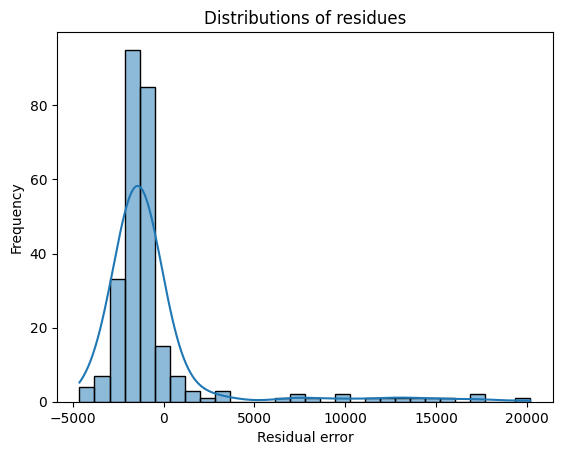

In [81]:
#Distributions of residues

y_pred = pipe.predict(X_test)
residuals = y_test - y_pred

sns.histplot(residuals, kde=True, bins=30)
plt.title("Distributions of residues")
plt.xlabel("Residual error")
plt.ylabel("Frequency")
plt.show()

/home/ludivine/Documents/prime_assurance/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


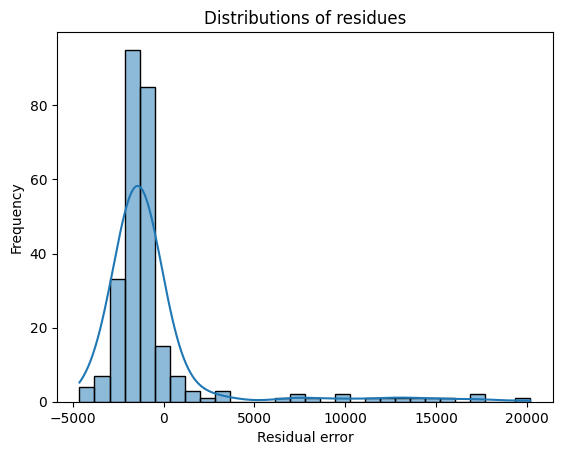

In [46]:
#Distributions of residues

y_pred = pipe.predict(X_test)
residuals = y_test - y_pred
resisuals=np.log1p(residuals)
sns.histplot(residuals, kde=True, bins=30)
plt.title("Distributions of residues")
plt.xlabel("Residual error")
plt.ylabel("Frequency")
plt.show()

The distribution follows a normal law but it is not centered on 0. It seems to follow the inital charges distributions. Here we have a systemic bias.

In [47]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error : {mse}")
print(f"R² Score : {r2}")


Mean Squared Error : 12336821.732248966
R² Score : 0.9144200561213408


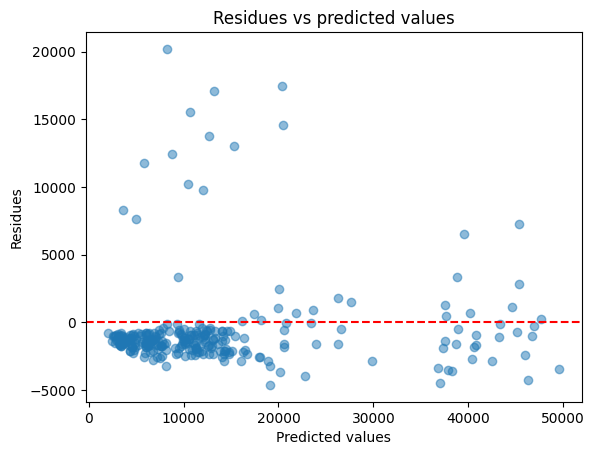

In [48]:
#Graph residues vs predict values

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residues vs predicted values")
plt.xlabel("Predicted values")
plt.ylabel("Residues")
plt.show()

Here again, values should be near 0 without a clear structure... Is it really the case here?

                                           Feature  Coefficient
12           ordinal__smoker ordinal__bmi_category  6180.710268
1                                  ordinal__smoker  5011.634627
10                                   r_scaler__age  3423.839930
9                                 scaler__children   862.373200
65                                 r_scaler__age^2   713.892241
..                                             ...          ...
19                ordinal__smoker scaler__children  -143.720203
42       onehot__sex_male onehot__region_southwest  -145.229884
41       onehot__sex_male onehot__region_southeast  -171.297427
63                              scaler__children^2  -193.821508
27  ordinal__bmi_category onehot__region_southwest  -263.862267

[66 rows x 2 columns]


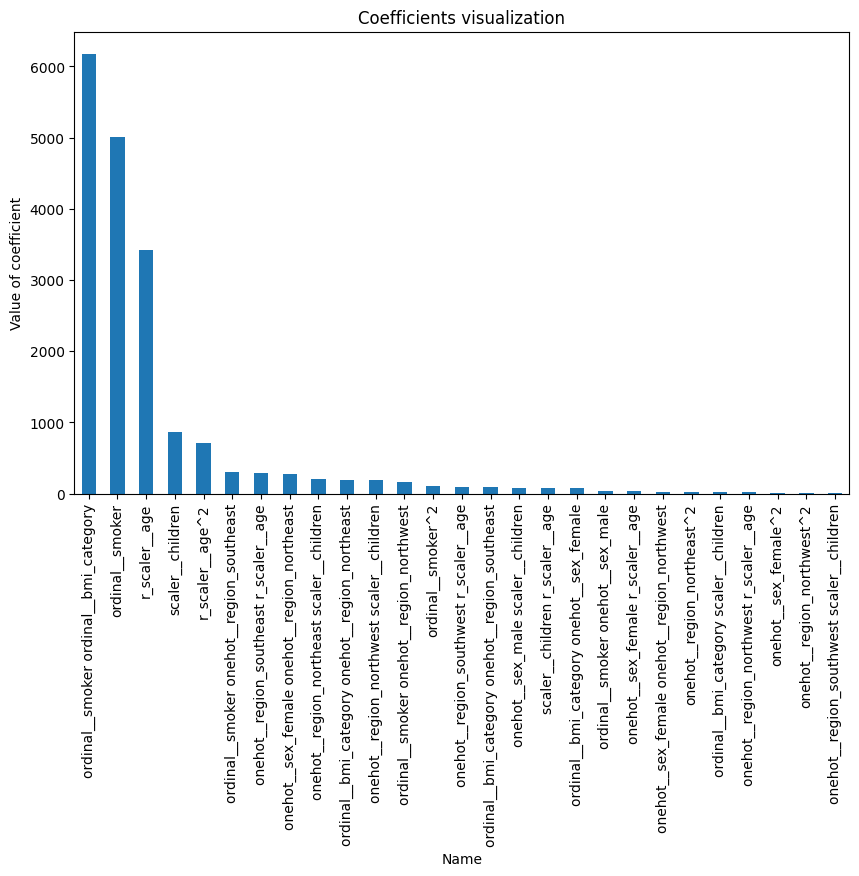

In [74]:
##Coefficient analysis
X = df.drop(columns=["charges"]) 
y = df["charges"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['smoker'])

#Pipeline with explicit names
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("polynomial", polynomial),
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=10, random_state=42))
])


pipe.fit(X_train, y_train)
#Coefficient extraction
coef = pipe.named_steps['lasso'].coef_

#Extraction the names after preprocessus
features = pipe.named_steps['preprocessor'].get_feature_names_out()
poly_features = pipe.named_steps['polynomial'].get_feature_names_out(features)

#DataFrame of coefficients
coefficients_df = pd.DataFrame({"Feature": poly_features, "Coefficient": coef})
coefficients_df = coefficients_df.sort_values(by="Coefficient", ascending=False)

positive_coefficients_df = coefficients_df[coefficients_df["Coefficient"] > 1]
print(coefficients_df)

#Visualization of coefficients
positive_coefficients_df.plot(kind='bar', x='Feature', y='Coefficient', figsize=(10, 6), legend=False)
plt.title("Coefficients visualization")
plt.ylabel("Value of coefficient")
plt.xlabel("Name")
plt.show()


                                           Feature  Coefficient
12           ordinal__smoker ordinal__bmi_category  6180.710268
1                                  ordinal__smoker  5011.634627
10                                   r_scaler__age  3423.839930
9                                 scaler__children   862.373200
65                                 r_scaler__age^2   713.892241
..                                             ...          ...
19                ordinal__smoker scaler__children  -143.720203
42       onehot__sex_male onehot__region_southwest  -145.229884
41       onehot__sex_male onehot__region_southeast  -171.297427
63                              scaler__children^2  -193.821508
27  ordinal__bmi_category onehot__region_southwest  -263.862267

[66 rows x 2 columns]


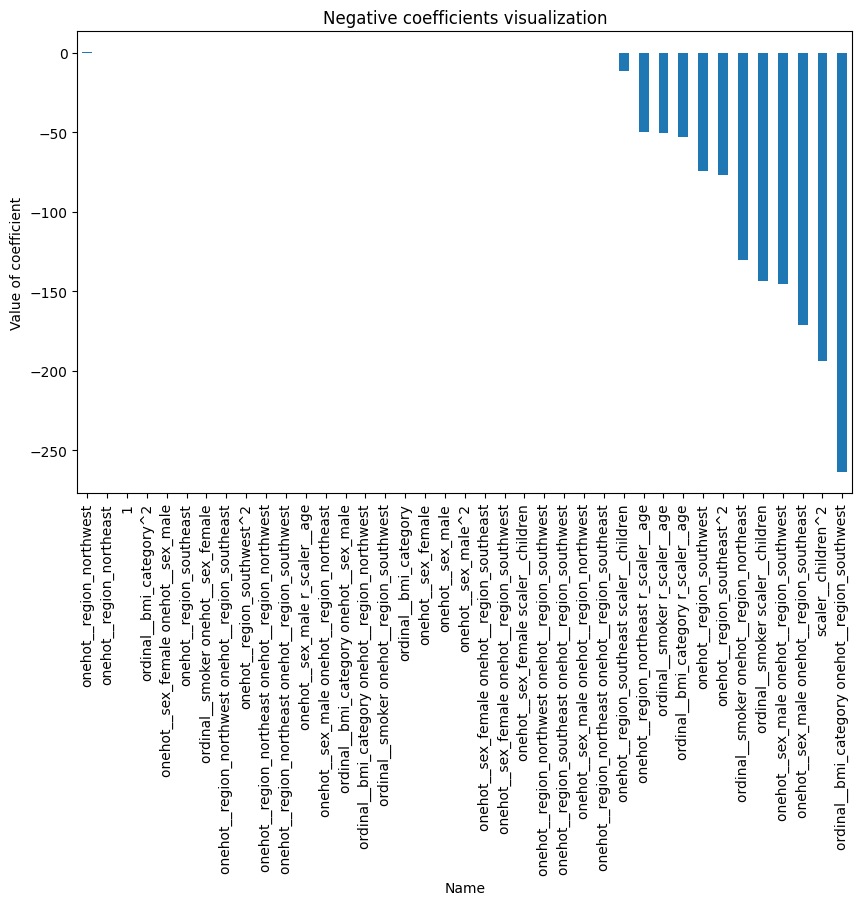

In [80]:
##Coefficient analysis
X = df.drop(columns=["charges"]) 
y = df["charges"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['smoker'])

#Pipeline with explicit names
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("polynomial", polynomial),
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=10, random_state=42))
])


pipe.fit(X_train, y_train)
#Coefficient extraction
coef = pipe.named_steps['lasso'].coef_

#Extraction the names after preprocessus
features = pipe.named_steps['preprocessor'].get_feature_names_out()
poly_features = pipe.named_steps['polynomial'].get_feature_names_out(features)

#DataFrame of coefficients
coefficients_df = pd.DataFrame({"Feature": poly_features, "Coefficient": coef})
coefficients_df = coefficients_df.sort_values(by="Coefficient", ascending=False)

negative_coefficients_df = coefficients_df[coefficients_df["Coefficient"] < 1]
print(coefficients_df)

#Visualization of coefficients
negative_coefficients_df.plot(kind='bar', x='Feature', y='Coefficient', figsize=(10, 6), legend=False)
plt.title("Negative coefficients visualization")
plt.ylabel("Value of coefficient")
plt.xlabel("Name")
plt.show()


In [50]:
#Polynomial interactions

poly_features = pipe.named_steps['polynomial'].get_feature_names_out(features)
poly_coefficients_df = pd.DataFrame({"Feature": poly_features, "Coefficient": coef})
poly_coefficients_df = poly_coefficients_df.sort_values(by="Coefficient", ascending=False)
print(poly_coefficients_df.head(10))  


                                           Feature  Coefficient
12           ordinal__smoker ordinal__bmi_category  6180.710268
1                                  ordinal__smoker  5011.634627
10                                   r_scaler__age  3423.839930
9                                 scaler__children   862.373200
65                                 r_scaler__age^2   713.892241
17        ordinal__smoker onehot__region_southeast   306.168470
59          onehot__region_southeast r_scaler__age   287.496945
32     onehot__sex_female onehot__region_northeast   273.590208
49       onehot__region_northeast scaler__children   206.700093
24  ordinal__bmi_category onehot__region_northeast   190.127411


In [51]:
#Cross-validation

scores = cross_val_score(pipe, X, y, cv=5, scoring='r2')
print(f"Score of cross-validation : {scores}")
print(f"Mean score: {scores.mean()}, Standard deviation: {scores.std()}")

Score of cross-validation : [0.88706403 0.79128496 0.88921662 0.84849517 0.87282513]
Mean score: 0.8577771824932604, Standard deviation: 0.03627662946326295


The standard deviation seems relatively small, so we can conclude that our model is strong.

In [82]:
##Error analysis

#Comparison of the predicted values and real values
error_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred, "Residual": residuals})
error_df['Relative_Error'] = error_df['Residual'] / error_df['Actual']
print(error_df.sort_values(by='Residual', ascending=False).head(10))  


           Actual     Predicted      Residual  Relative_Error
805   28476.73499   8273.530060  20203.204930        0.709464
1302  37829.72420  20359.563309  17470.160891        0.461810
115   30259.99556  13160.632611  17099.362949        0.565081
875   26140.36030  10636.157985  15504.202315        0.593114
916   35069.37452  20490.873562  14578.500958        0.415705
963   26467.09737  12720.845821  13746.251549        0.519371
443   28287.89766  15289.101303  12998.796357        0.459518
1002  21232.18226   8799.227023  12432.955237        0.585571
582   17626.23951   5825.117954  11801.121556        0.669520
45    20630.28351  10409.528468  10220.755042        0.495425


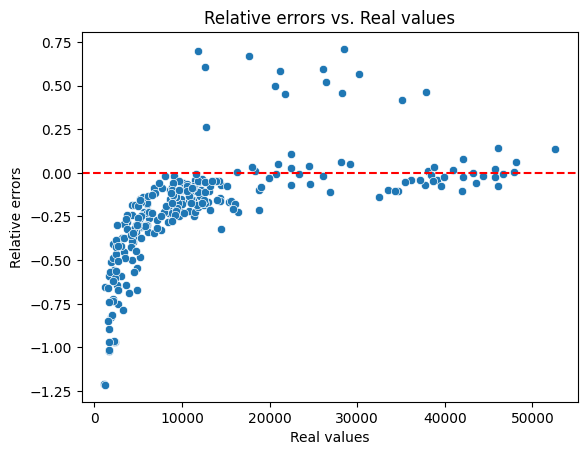

In [83]:
sns.scatterplot(data=error_df, x='Actual', y='Relative_Error')
plt.axhline(0, color='red', linestyle='--')
plt.title("Relative errors vs. Real values")
plt.xlabel("Real values")
plt.ylabel("Relative errors")
plt.show()


The error analysis reveal that our model is suitable to predict large value of charges but not for small charges.

## Possibilité d'amélioration
7. Tests d'Assomptions

Si vous utilisez une régression, vérifiez que les hypothèses du modèle sont respectées.

    Linéarité : Les relations entre les prédicteurs et la cible doivent être linéaires (sinon, transformations supplémentaires).
    Homoscédasticité : Les résidus devraient avoir une variance constante (vérifié via le graphique des résidus).
    Indépendance des erreurs : Assurez-vous que les erreurs ne présentent pas de schéma temporel ou structurel.
    Normalité des erreurs : Les erreurs doivent suivre une distribution normale (via Shapiro-Wilk ou Kolmogorov-Smirnov).

8. Essai d'autres Modèles

Pour confirmer que votre modèle est le meilleur choix :

    Essayez des modèles non linéaires comme Gradient Boosting ou Random Forest.
    Comparez leurs performances avec votre modèle actuel.

## Exportation of the model in pickle format

In [54]:
X = df.drop(columns=["charges"]) 
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['smoker'])

pipe.fit(X_train, y_train)
#Save the pipeline
with open("model_pipeline.pkl", "wb") as file:
    pickle.dump(pipe, file)

In [55]:
with open("model_pipeline.pkl", "rb") as file:
    loaded_model = pickle.load(file)

# Test with a sample
sample_data = X_test.iloc[0:1]  # EOne data 
prediction = loaded_model.predict(sample_data)
print(f"Prediction : {prediction}")



Prediction : [12805.60658536]


In [56]:
score_train = pipe.score(X_train, y_train)
score_test = pipe.score(X_test, y_test)
print(f'score train : {score_train} - score test : {score_test}')

score train : 0.8545542214903947 - score test : 0.9144200561213408


In [57]:
df1 = pd.read_csv('cleansed_data.csv')
df1

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,10600.54830
1333,18,female,31.920,0,no,northeast,2205.98080
1334,18,female,36.850,0,no,southeast,1629.83350
1335,21,female,25.800,0,no,southwest,2007.94500


In [58]:
# Function to transform bmi in categorical value
def transform_bmi(X):
    bins = [0, 29.999, 100]
    labels = ['Normal weight', 'Obesity']
    X = X.copy()
    X["bmi_category"] = pd.cut(X['bmi'], bins=bins, labels=labels, right=False)
    return X

In [59]:
# Creation of a personnalized function 
bmi_transformer = FunctionTransformer(transform_bmi)

# Split the datas
X = df1.drop(columns=["charges"])
y = df1["charges"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['smoker'])

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("ordinal", OrdinalEncoder(), ["smoker", "bmi_category"]),  
        ("onehot", OneHotEncoder(sparse_output=False), ["sex", "region"]), 
        ("scaler", StandardScaler(), ["children"]),
        ("r_scaler", RobustScaler(), ["age"])
    ],
    remainder="drop"  
)

# Creation of the final pipeline
pipe = make_pipeline(
    bmi_transformer,            # Bmi transformation step
    preprocessor,               
    PolynomialFeatures(degree=2, interaction_only=False),
    StandardScaler(),
    Lasso(alpha=10, random_state=42)
)

# Training of the pipeline
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function transform_bmi at 0x70e40160b560>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['smoker', 'bmi_category']),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['sex', 'region']),
                                                 ('scaler', StandardScaler(),
                                                  ['children']),
                                                 ('r_scaler', RobustScaler(),
                                                  ['age'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=10, random_state=42))])

In [60]:
score_train = pipe.score(X_train, y_train)
score_test = pipe.score(X_test, y_test)
print(f'score train : {score_train} - score test : {score_test}')

score train : 0.8545542214903947 - score test : 0.9144200561213408


In [61]:
X = df1.drop(columns=["charges"]) 
y = df1["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['smoker'])

pipe.fit(X_train, y_train)

#import pickle
with open("model_pipeline.pkl", "wb") as file:
    pickle.dump(pipe, file)

In [62]:
with open("model_pipeline.pkl", "rb") as file:
    loaded_model = pickle.load(file)


sample_data = X_test.iloc[0:1]  
prediction = loaded_model.predict(sample_data)
print(f"Prédiction : {prediction}")


Prédiction : [12805.60658536]
